In [299]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from scipy.stats import randint, uniform
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap


In [300]:
parts_data = pd.read_csv('/Users/skylerwilson/Desktop/Lighthouse_Labs/Projects/final_project/data/Project_Data/final_parts_data.csv')

In [301]:
# Clean sales data function
def clean_sales_data(df, column_names):
    for col in column_names:  
        df[col] = np.abs(df[col])
    return df

# Clean quantity data function
def clean_quantity_data(df, quantity_col):
    return df[df[quantity_col] > 0]

# Clean turnover data function
def clean_negative_data(df, turnover_col):
    return df[df[turnover_col] >= 0]


def z_score(column, threshold=2):
    z_scores = (column - column.mean()) / column.std()
    return np.abs(z_scores) < threshold

sales_data = ['Sales Last Month', 'Sales Last 3 Months', 'Sales Last 6 Months', 'Sales Last 9 Months',
              'Sales Last 12 Months', 'Sales Last 2 Years', 'Sales Last 3 Years',
              'Sales Last 4 Years', 'Sales Last 5 Years', 'Sales Last 10 Years',
              'Months No Sale', 'Reorder Point', 'Sales - Jan', 'Sales - Feb',
              'Sales - Mar', 'Sales - Apr', 'Sales - May', 'Sales - Jun',
              'Sales - Jul', 'Sales - Aug', 'Sales - Sep', 'Sales - Oct',
              'Sales - Nov', 'Sales - Dec', 'Sales - 1st Qtr', 'Sales - 2nd Qtr',
              'Sales - 3rd Qtr', 'Sales - 4th Qtr', 'Sales - This Year','Sales - Last Year']
quantity_col = 'Quantity'
turnover_col = 'Turnover'

num_cols = parts_data.select_dtypes(include='number').columns

# Apply preprocessing steps
parts_data = clean_sales_data(parts_data, sales_data)
parts_data = clean_quantity_data(parts_data, quantity_col)
parts_data = clean_negative_data(parts_data, turnover_col)


# Apply z-score transformation to numerical columns
parts_data[num_cols] = parts_data[parts_data[num_cols].apply(z_score)][num_cols]

#deals with columns that dont have data yet so they end up as NaN when they shouldnt
parts_data[num_cols] = np.where(parts_data[num_cols].isna(), 0, parts_data[num_cols])



In [302]:
# Custom transformer classes
class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        transformed_data = X.copy()
        for col in self.columns:
            transformed_data[col], _ = yeojohnson(X[col] + 0.01)  # Adding 0.01 to avoid zero values
        return transformed_data

# Load and preprocess the data
y = parts_data['Customer LTV']
X = parts_data.select_dtypes(include='number').drop(columns=['Customer LTV'])
constant_columns = X.columns[X.nunique() == 1]
X.drop(columns=constant_columns, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Define columns to transform
cols_to_transform = X.columns

# Column transformer for Yeo-Johnson transformation
yeo_johnson_cols = ColumnTransformer(
    transformers=[('yeo_johnson', YeoJohnsonTransformer(columns=cols_to_transform), cols_to_transform)],
    remainder='passthrough'
)

# Create FeatureUnion combining TruncatedSVD and SelectKBest
features = FeatureUnion([
    ('svd', TruncatedSVD(n_components=3)),
    ('select_k_best', SelectKBest(score_func=f_regression, k=4))
])

final_pipeline = Pipeline([
    ('transformer', yeo_johnson_cols),
    ('features', features),
    ('scaler', RobustScaler())
])

final_pipeline.fit(X_train, y_train)

X_train_transformed = final_pipeline.named_steps['transformer'].transform(X_train)
X_train_transformed = final_pipeline.named_steps['features'].transform(X_train_transformed)
X_train_transformed = final_pipeline.named_steps['scaler'].transform(X_train_transformed)

# Create a DataFrame with transformed and non-transformed data
X_train_transformed_df = pd.DataFrame(
    np.hstack((X_train_transformed, X_train.drop(columns=cols_to_transform))),
    columns=final_pipeline.named_steps['features'].get_feature_names_out(input_features=X_train.columns),
    index=X_train.index
)

# Transform the testing data using the pipeline
X_test_transformed = final_pipeline.named_steps['transformer'].transform(X_test)
X_test_transformed = final_pipeline.named_steps['features'].transform(X_test_transformed)
X_test_transformed = final_pipeline.named_steps['scaler'].transform(X_test_transformed)

X_test_transformed_df = pd.DataFrame(
    np.hstack((X_test_transformed, X_test.drop(columns=cols_to_transform))),
    columns=final_pipeline.named_steps['features'].get_feature_names_out(input_features=X_test.columns),
    index=X_test.index
)

regressor=XGBRegressor(
    colsample_bytree=0.9,
    gamma=2.5,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=9,
    n_estimators=129,
    reg_alpha=0.2,
    reg_lambda=0.2,
    subsample=0.8,
    early_stopping_rounds=20

)
regressor.fit(X_train_transformed, y_train, 
        eval_set=[(X_train_transformed, y_train), (X_test_transformed, y_test)])

y_pred = regressor.predict(X_test_transformed)



[0]	validation_0-rmse:1598.57948	validation_1-rmse:1575.05337
[1]	validation_0-rmse:1438.86055	validation_1-rmse:1421.81588
[2]	validation_0-rmse:1295.05605	validation_1-rmse:1283.64038
[3]	validation_0-rmse:1165.65681	validation_1-rmse:1160.04863
[4]	validation_0-rmse:1049.15315	validation_1-rmse:1048.13318
[5]	validation_0-rmse:944.30149	validation_1-rmse:947.98894
[6]	validation_0-rmse:849.92511	validation_1-rmse:858.21895
[7]	validation_0-rmse:765.01214	validation_1-rmse:777.22886
[8]	validation_0-rmse:688.55885	validation_1-rmse:704.13228
[9]	validation_0-rmse:619.81402	validation_1-rmse:638.91800
[10]	validation_0-rmse:557.90884	validation_1-rmse:579.72465
[11]	validation_0-rmse:505.04205	validation_1-rmse:531.22673
[12]	validation_0-rmse:454.60305	validation_1-rmse:483.68484
[13]	validation_0-rmse:409.16131	validation_1-rmse:440.61954
[14]	validation_0-rmse:368.29652	validation_1-rmse:402.28918
[15]	validation_0-rmse:331.50031	validation_1-rmse:367.64896
[16]	validation_0-rmse:2

In [303]:
import math
# Evaluate your model using appropriate metrics
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

r_squared = r2_score(y_test, y_pred)
print(f'R squared Value: {r_squared}')


Mean Squared Error: 6426.391817626783
Root Mean Squared Error: 80.16477915909694
Mean Absolute Error: 22.487596108810546
R squared Value: 0.9971548199894559


In [304]:
import plotly.express as px

# Create an interactive scatterplot using Plotly
fig = px.scatter(x=y_test, y=y_pred, labels={'x': 'Actual Values (y_test)', 'y': 'Predicted Values (y_pred)'},
                 title='Actual vs. Predicted Values')
fig.update_layout(showlegend=False, template='plotly')
fig.show()


In [305]:
# Initialize the SHAP explainer using the transformed training data
explainer = shap.Explainer(regressor)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_transformed, check_additivity=False)

In [306]:
shap_values.shape

(3111, 7)

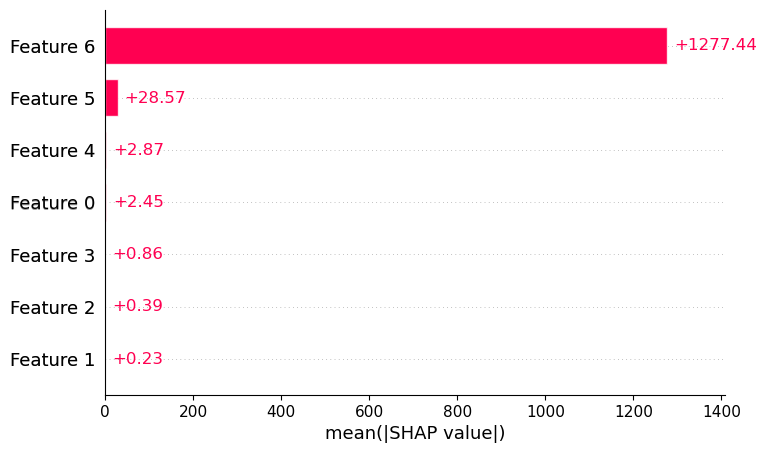

In [307]:
shap.plots.bar(shap_values, max_display=8)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/shap/plots/_beeswarm.py:375: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



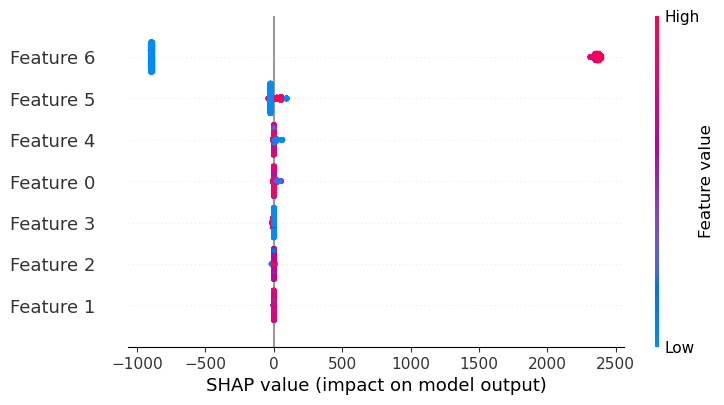

In [308]:
shap.plots.beeswarm(shap_values, max_display=8)  # Customize the color to blue


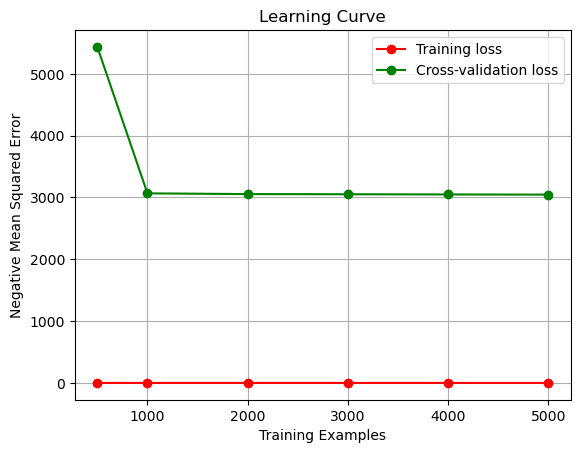

In [309]:
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, cv, train_sizes):
    train_sizes, train_scores, test_scores = learning_curve(
        regressor_model, X, y, cv=cv, train_sizes=train_sizes,
        scoring=make_scorer(mean_squared_error), n_jobs=-1
    )

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Negative Mean Squared Error")
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training loss")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation loss")

    plt.legend(loc="best")
    plt.show()

# Define the train sizes for the learning curve
train_sizes = [500, 1000, 2000, 3000, 4000, 5000]

# Use the final_pipeline to plot the learning curve
plot_learning_curve(final_pipeline, X_train, y_train, cv=5, train_sizes=train_sizes)
